In [2]:
!pip install transformers tensorflow tensorflow-hub

In [3]:
from transformers import CLIPProcessor, TFCLIPModel
from PIL import Image
import tensorflow as tf
import os
import numpy as np

# Load the CLIP model and processor
model_name = "openai/clip-vit-base-patch32"  # Pretrained CLIP model
model = TFCLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

# Give your folder path to extract the image files.
# folder = r"D:\image_suggestion\Some_images" 

# Get a list of all image files
image_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif")
image_files = [f for f in os.listdir(folder) if f.lower().endswith(image_extensions)]



All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


In [11]:
# MAKE YOUR OWN QDRANT CLIENT.

# from qdrant_client import QdrantClient , models
# client = QdrantClient(url = "http://localhost:6333")

In [12]:
# AFTER 

client.create_collection(
    collection_name="image_suggestion",
    vectors_config={
        "image": models.VectorParams(size=512, distance=models.Distance.COSINE),
    },
)

True

In [13]:
# Load and preprocess the image
for i in range(len(image_files)):
     image_path = os.path.join(folder, image_files[i])  
     image = Image.open(image_path).convert("RGB")
     inputs = processor(images=image, return_tensors="tf", padding=True)

# Generate semantic embeddings
     image_features = model.get_image_features(**inputs)

# Normalize the embeddings for cosine similarity
     image_embeddings = tf.linalg.l2_normalize(image_features, axis=-1)
     client.upsert(
        collection_name="image_suggestion",
        points=[
           models.PointStruct(
              id=i,
              payload={
                "name": image_files[i],
              },
              vector={"image" : image_embeddings[0]},
                              ),
               ],
                   )
 

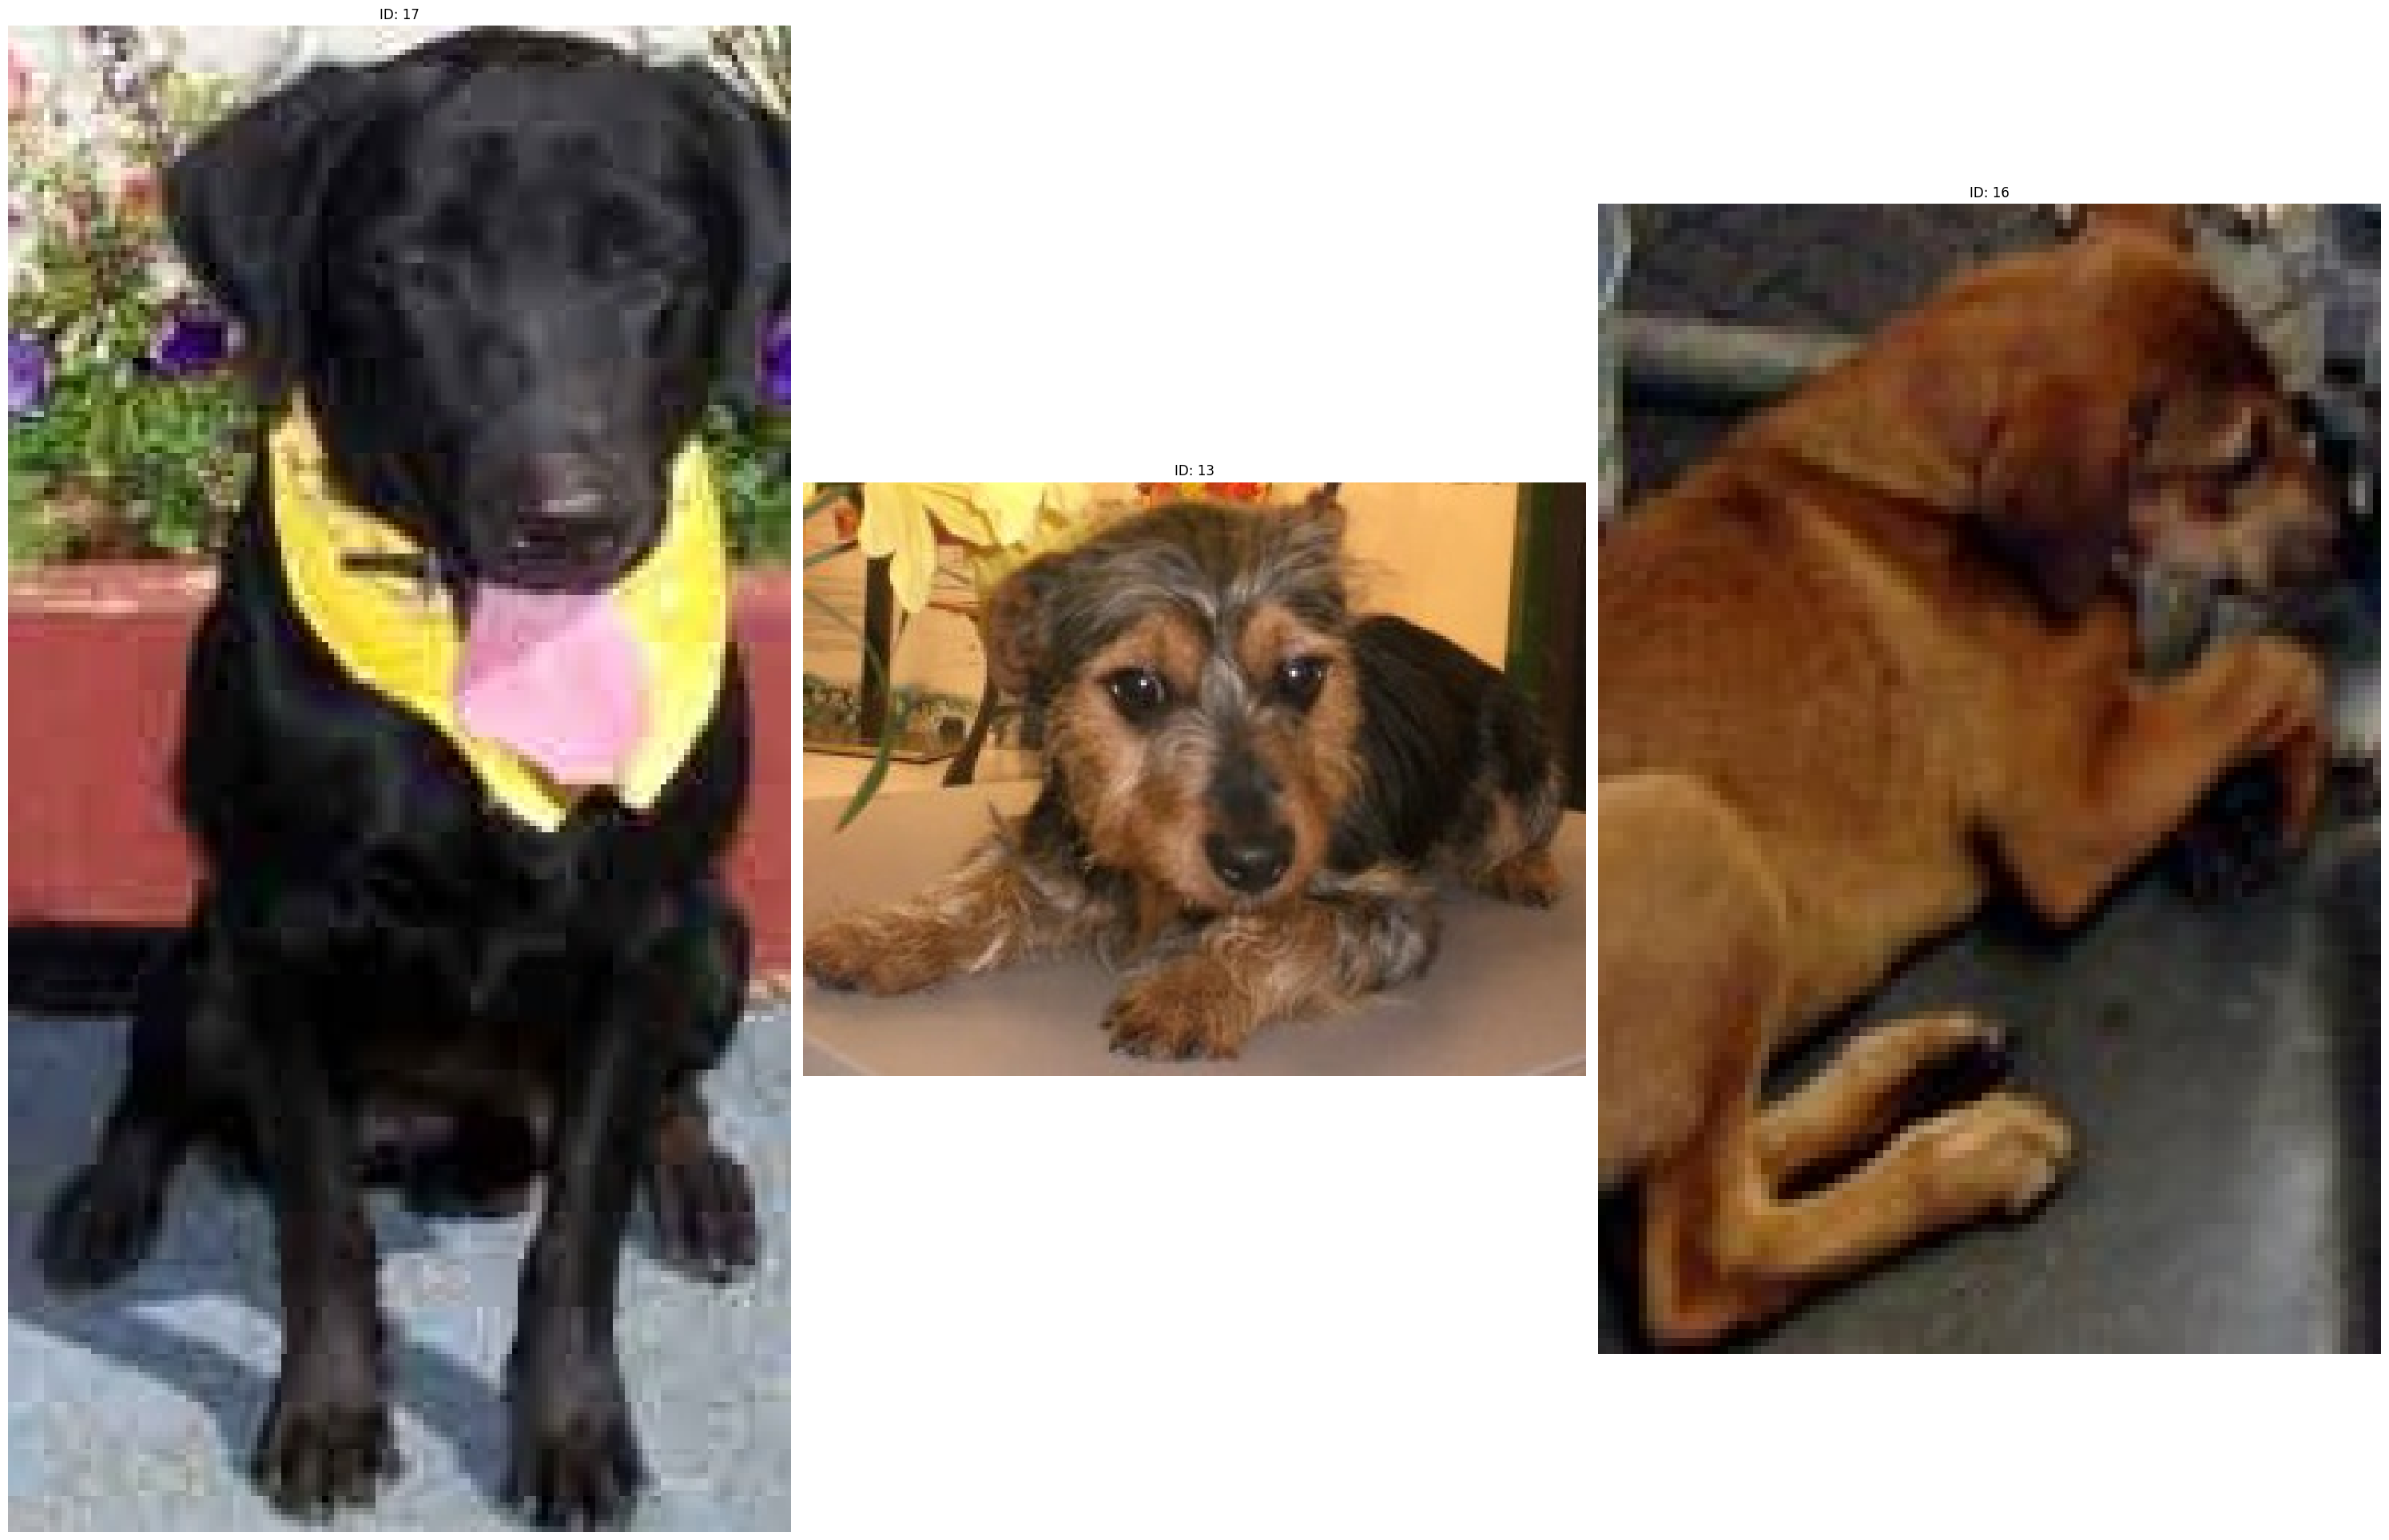

In [66]:
image_path = r"dog.jpeg"
image = Image.open(image_path).convert("RGB")
inputs = processor(images=image, return_tensors="tf", padding=True)

# Generate semantic embeddings
image_features = model.get_image_features(**inputs)

# Normalize the embeddings for cosine similarity
image_embeddings = tf.linalg.l2_normalize(image_features, axis=-1)

# Save or use the embeddings
embedding_list = image_embeddings[0].numpy().tolist()

points = list(client.query_points(
    collection_name="image_suggestion",
    query=embedding_list,
    using="image",
    limit=3,
))

ids = []
for i in range(3):
    ids.append(points[0][1][i].id)

fig, axes = plt.subplots(1, len(ids), figsize=(30, 30))

# Loop through IDs and display images
for ax, img_id in zip(axes, ids):
    image_path = os.path.join(folder, image_files[img_id]) 
    try:
        img = Image.open(image_path)
        ax.imshow(img)
        ax.axis("off")  # Hide axes
        ax.set_title(f"ID: {img_id}")
    except FileNotFoundError:
        ax.text(0.5, 0.5, "Image not found", ha="center", va="center", fontsize=12)
        ax.axis("off")

plt.tight_layout()
plt.show()